In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from statsmodels.tsa.ardl import ardl_select_order
from statsmodels.tsa.ardl import ARDL

import numpy as np
import os 
import sys
#sys.path.append("../src/model")
sys.path.append(os.path.abspath("../../src/model/"))

from pprint import pprint

from ARDL_model import *

DATA_PATH_CLEAN = "../data/CLEAN"

DATA_PATH = "../../data/CLEAN/FBI_Dataset_91_12/RAW/"



In [2]:
# Let's take an example with the state of Alabama
Alabama_data = pd.read_csv(DATA_PATH+"Alabama_violence.csv", sep=",")
display(Alabama_data)

,incident_id,incident_date,offense_category_name,year,date,week
0,66036917,2012-01-01 00:00:00,Assault Offenses,2012,2012-01-01,52
1,66036920,2012-01-01 00:00:00,Larceny/Theft Offenses,2012,2012-01-01,52
2,66036922,2012-01-01 00:00:00,Larceny/Theft Offenses,2012,2012-01-01,52
3,66036923,2012-01-01 00:00:00,Larceny/Theft Offenses,2012,2012-01-01,52
4,66036924,2012-01-01 00:00:00,Assault Offenses,2012,2012-01-01,52
...,...,...,...,...,...,...
347838,64304,1991-11-30 00:00:00,Larceny/Theft Offenses,1991,1991-11-30,48
347839,64307,1991-12-15 00:00:00,Larceny/Theft Offenses,1991,1991-12-15,50
347840,64306,1991-12-18 00:00:00,Larceny/Theft Offenses,1991,1991-12-18,51
347841,64305,1991-12-19 00:00:00,Larceny/Theft Offenses,1991,1991-12-19,51


In [3]:
all_states_names= os.listdir(DATA_PATH)

In [4]:
states_data = {}

for state in all_states_names:
    states_data[state[:-13]] = pd.read_csv(DATA_PATH+state, sep=",")


# Plots

Let's see just one state

<Axes: xlabel='week', ylabel='count_of_offenses'>

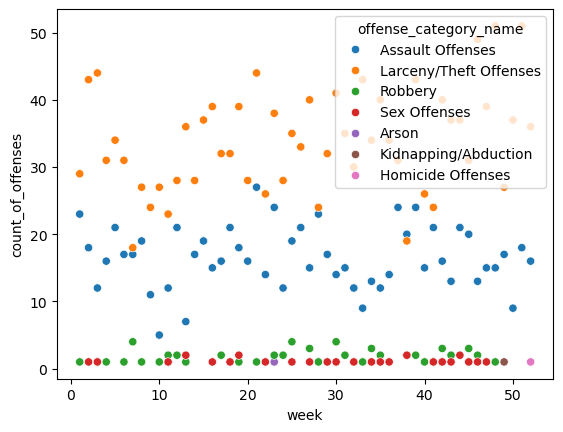

In [5]:
import seaborn as sns

# Perform the groupby operation and calculate size
group_sizes = Alabama_data.groupby(["year", "week", "offense_category_name"]).size()

# Reset the index and name the size column
result_df = group_sizes.reset_index(name='count_of_offenses')
sns.scatterplot(result_df[result_df.year==2008], x='week', y='count_of_offenses',hue='offense_category_name')

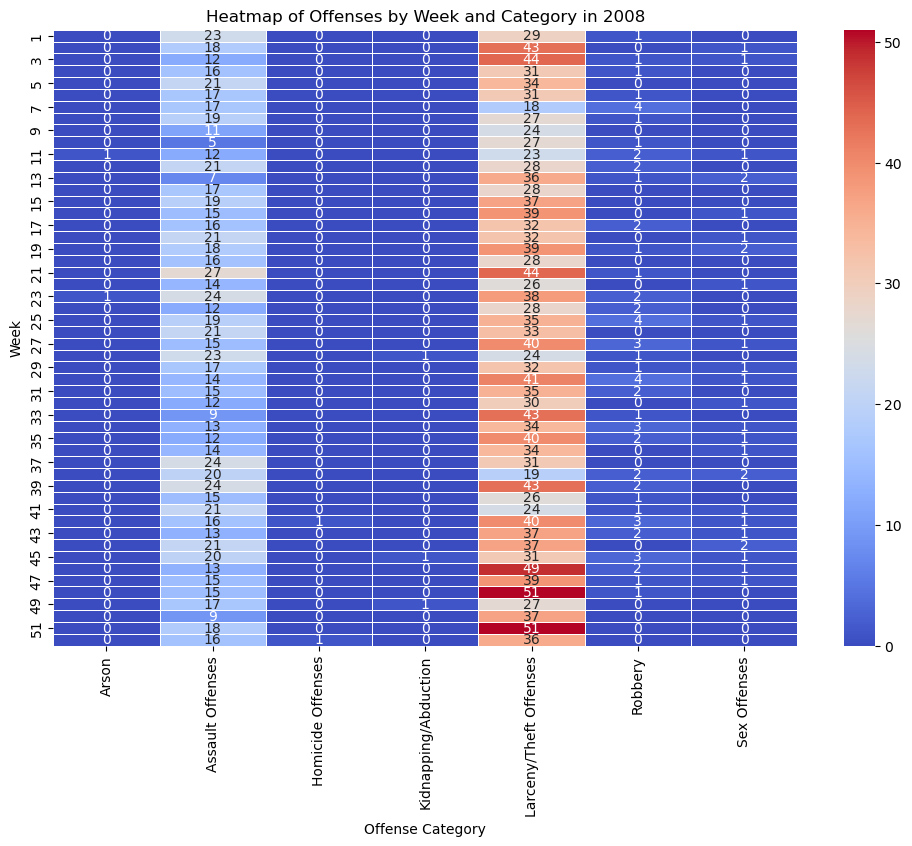

In [6]:
heatmap_data = result_df[result_df.year == 2008].pivot(index="week", columns="offense_category_name", values="count_of_offenses")
heatmap_data.fillna(0, inplace=True)  # Fill NaN values with 0

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', linewidths=.5)  # Annotate cells with counts
plt.title('Heatmap of Offenses by Week and Category in 2008')
plt.ylabel('Week')
plt.xlabel('Offense Category')
plt.show()

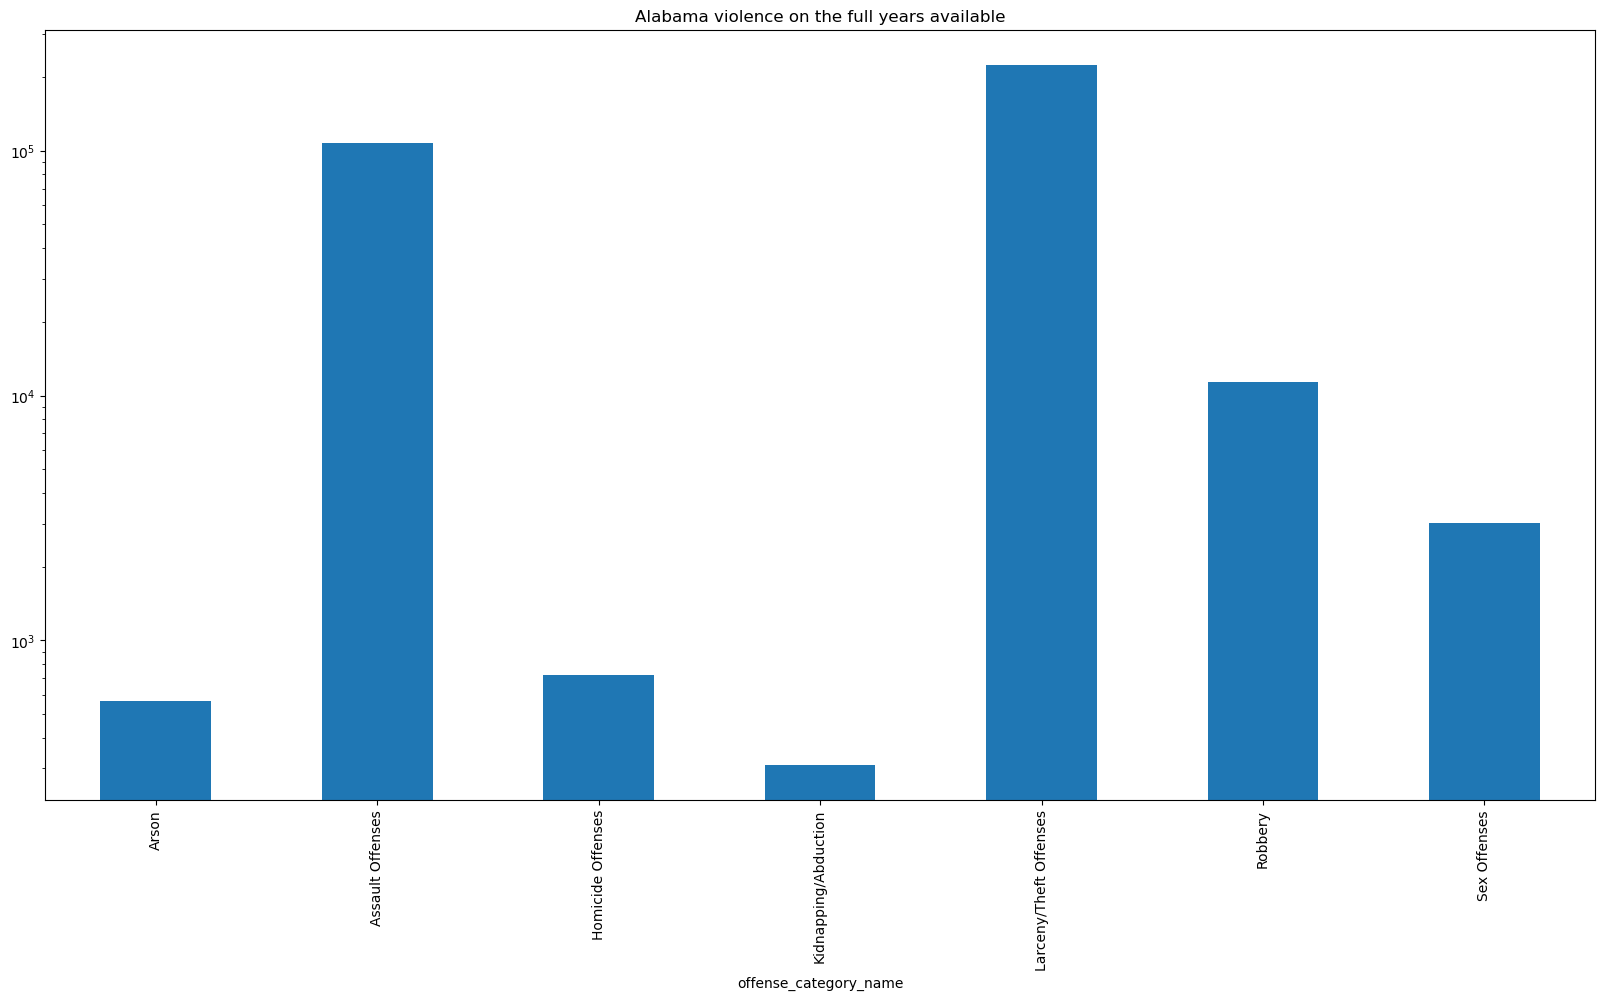

In [7]:
state = "Alabama"
plt.figure(figsize=(20,10))
states_data[state].groupby("offense_category_name").size().plot(kind="bar",logy=True)
plt.title(state +" violence on the full years available")
plt.show()

Let's observe all the states 

BEWARE OF THE YEAR CHOSEN SO THAT WE HAVE THE DATA OF EVERYONE 
IF INPUT THE MEDIAN THEN CONSIDER MORE DATA FROM FBI 

/tmp/ipykernel_12684/2899799109.py:9: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 10**8)
/tmp/ipykernel_12684/2899799109.py:9: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 10**8)
/tmp/ipykernel_12684/2899799109.py:9: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 10**8)
/tmp/ipykernel_12684/2899799109.py:9: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 10**8)
/tmp/ipykernel_12684/2899799109.py:9: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 10**8)
/tmp/ipykernel_12684/2899799109.py:9: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 10**8)
/tmp/ipykernel_12684/2899799109.py:9: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  

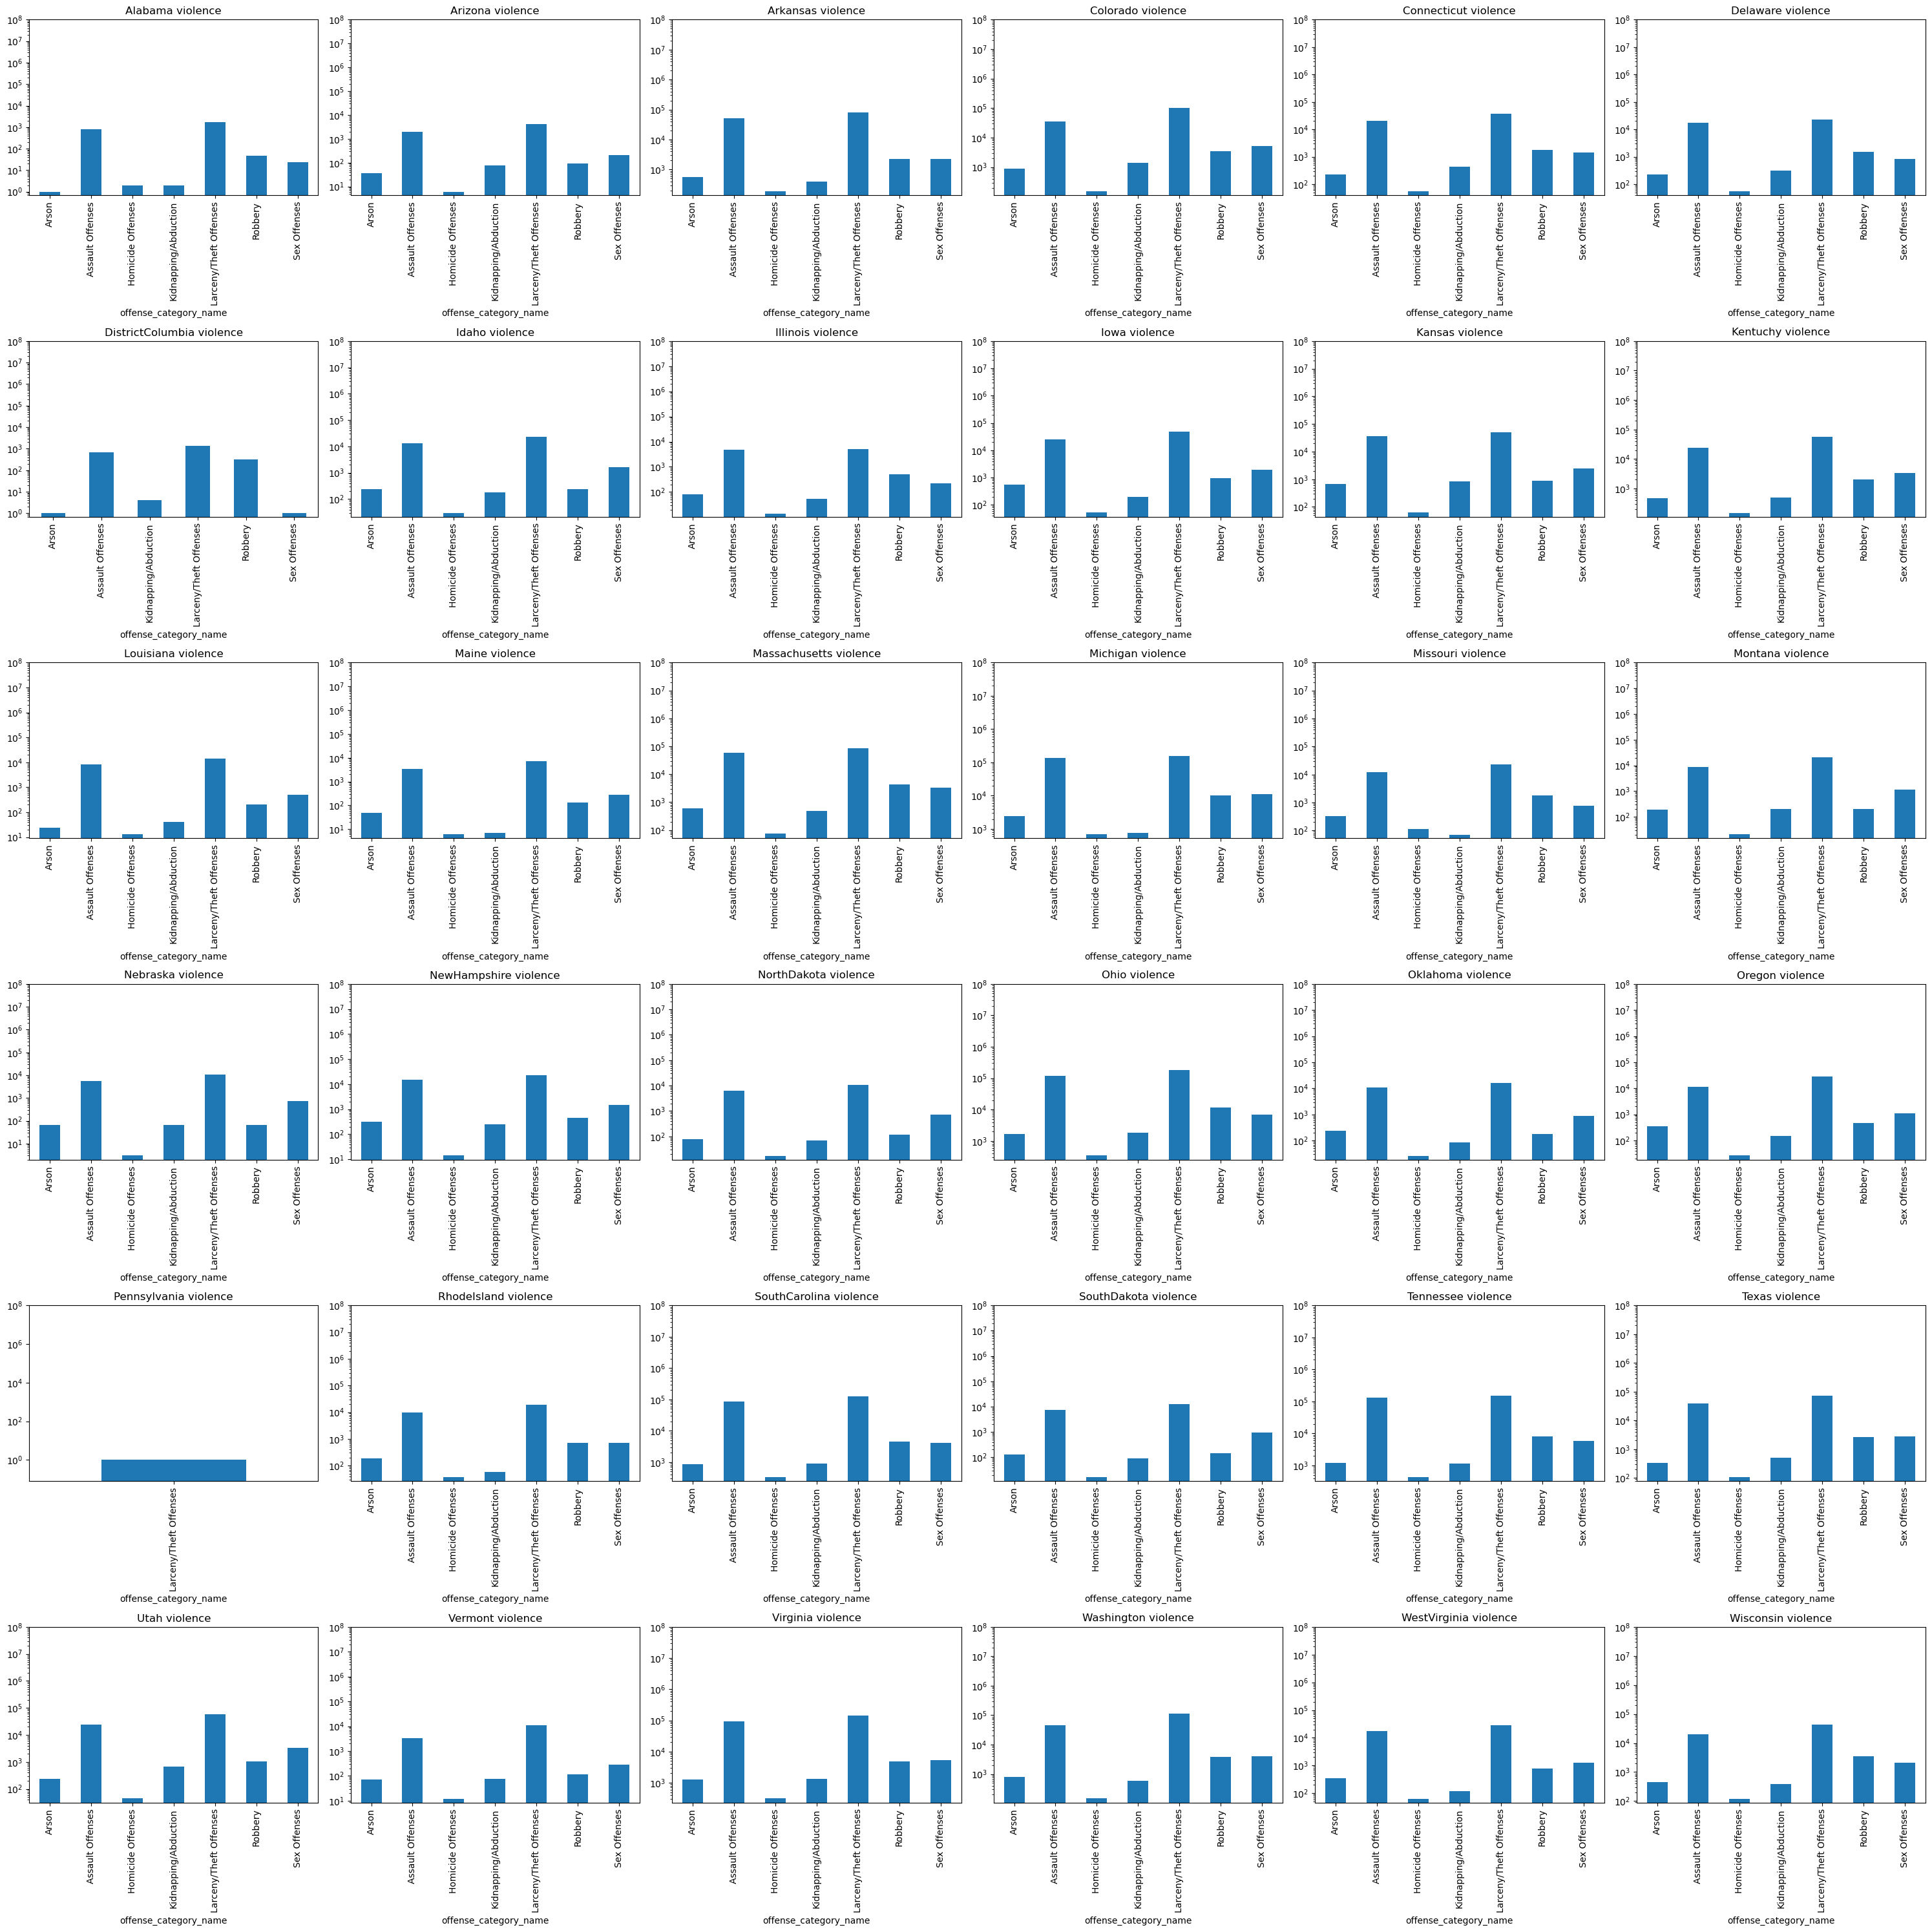

In [8]:
year = 2012
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(30, 30))
axes = axes.flatten()

for i, state in enumerate(all_states_names):
    ax = axes[i]
    states_data[state[:-13]][states_data[state[:-13]].year==year].groupby("offense_category_name").size().plot(kind="bar", logy=True, ax=ax)
    ax.set_title(state[:-13] + " violence")
    ax.set_ylim(0, 10**8)

plt.tight_layout()
plt.show()

In [9]:
states_years = {}
for state in all_states_names:
    states_years[state[:-13]] = sorted(states_data[state[:-13]].year.unique())


In [10]:
presence_df = pd.DataFrame(index= states_data.keys(),columns=np.arange(1991,2013))

# Populate the DataFrame
for state, years in states_years.items():
    presence_df.loc[state, years] = 1

presence_df.fillna(0, inplace=True)



/tmp/ipykernel_12684/1302278788.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  presence_df.fillna(0, inplace=True)


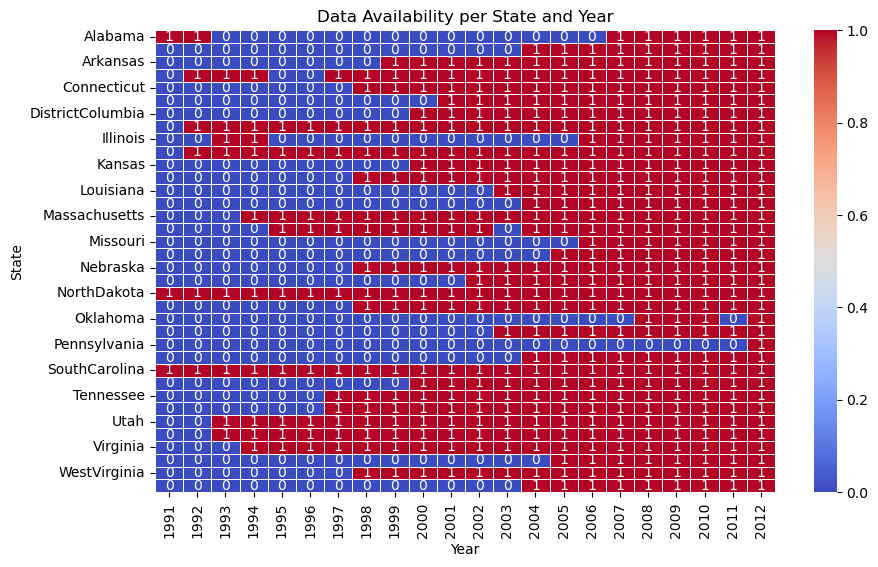

In [11]:
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.heatmap(presence_df, annot=True, cmap="coolwarm", cbar=True, linewidths=.5)
plt.title('Data Availability per State and Year')
plt.ylabel('State')
plt.xlabel('Year')
plt.show()

# Preprocessing 

In [12]:
def longest_consecutive_sequence(sorted_years):
    # Initialize variables to track the longest sequence
    max_length = 1
    current_length = 1
    start_year = sorted_years[0]
    best_start = start_year

    # Iterate through the sorted list and find the longest consecutive sequence
    for i in range(1, len(sorted_years)):
        if sorted_years[i] == sorted_years[i-1] + 1:
            current_length += 1
        else:
            if current_length > max_length:
                max_length = current_length
                best_start = start_year
            # Reset for the next sequence
            start_year = sorted_years[i]
            current_length = 1

    # Check the last sequence
    if current_length > max_length:
        best_start = start_year
        max_length = current_length

    # Create the list of the longest consecutive sequence
    longest_sequence = list(range(best_start, best_start + max_length))
    return longest_sequence

In [13]:

states_years_consecutive = pd.DataFrame(index= states_data.keys(),columns=["minimum_year", "maximum year"])
for state in all_states_names:
    sequence = longest_consecutive_sequence(states_years[state[:-13]])
    states_years_consecutive.loc[state[:-13], "minimum_year"] = np.min(sequence)
    states_years_consecutive.loc[state[:-13], "maximum year"] = np.max(sequence)

In [14]:
#save the data 
#states_years_consecutive.to_csv(DATA_PATH +"/Consecutive_years_states.tsv", sep="\t")

# Score by count and count ratio

In [15]:
# Real life score for weeks 
def real_life_violence_score_count(data,year,start_week,stop_week,ratio=False): 
    extracted_data = data[(data.year==year) & (data.week >=start_week) & (data.week <=stop_week)]
    weekly_score = extracted_data.groupby("week").size()
    if ratio: 
        weekly_score/=len(extracted_data)

    return weekly_score


In [16]:
Alabama_data

,incident_id,incident_date,offense_category_name,year,date,week
0,66036917,2012-01-01 00:00:00,Assault Offenses,2012,2012-01-01,52
1,66036920,2012-01-01 00:00:00,Larceny/Theft Offenses,2012,2012-01-01,52
2,66036922,2012-01-01 00:00:00,Larceny/Theft Offenses,2012,2012-01-01,52
3,66036923,2012-01-01 00:00:00,Larceny/Theft Offenses,2012,2012-01-01,52
4,66036924,2012-01-01 00:00:00,Assault Offenses,2012,2012-01-01,52
...,...,...,...,...,...,...
347838,64304,1991-11-30 00:00:00,Larceny/Theft Offenses,1991,1991-11-30,48
347839,64307,1991-12-15 00:00:00,Larceny/Theft Offenses,1991,1991-12-15,50
347840,64306,1991-12-18 00:00:00,Larceny/Theft Offenses,1991,1991-12-18,51
347841,64305,1991-12-19 00:00:00,Larceny/Theft Offenses,1991,1991-12-19,51


In [17]:
# Specify the data (state for now, has to apply to each and then merge results)
# Specify the year (right now can't take multiple years, have to solve this)
# Specify the start and stop weeks
# Specify if you want the ratio or the count
real_life_violence_score_count(Alabama_data,2008,10,14,True)


week
10    0.154206
11    0.182243
12    0.238318
13    0.214953
14    0.210280
dtype: float64

# Score taking into account the different categories of offenses 

In [18]:
def categorisation_violence (data,year,start_week,stop_week, window_size=6, offenses = ['Assault Offenses', 'Larceny/Theft Offenses', 'Robbery',
       'Sex Offenses', 'Kidnapping/Abduction', 'Arson',
       'Homicide Offenses']):
       extracted_data = data[(data.year==year) & (data.week >=start_week) & (data.week <=stop_week)]
       category_size = extracted_data.groupby(["year", "week", "offense_category_name"]).size()
       result_df = category_size.reset_index(name='count_of_offenses')
       return result_df
       

In [19]:
def normalise_violent_category(extracted_data, offense,window_size=6):
    if offense in extracted_data['offense_category_name'].values:
        extracted_category = extracted_data[extracted_data.offense_category_name == offense].copy()
        rolling_mean = extracted_category.count_of_offenses.rolling(window=window_size, min_periods=1).mean()
        rolling_std = extracted_category.count_of_offenses.rolling(window=window_size, min_periods=1).std().fillna(1) # avoid division by 0 and enable to have 0 as z-score since z-score not applicable in that case
        extracted_category.loc[:, 'z_score'] = (extracted_category.count_of_offenses - rolling_mean ) / rolling_std
    else: 
        extracted_category = pd.DataFrame()
    return extracted_category
    

In [20]:

def real_life_violence_score_z_score(data,year,start_week,stop_week, window_size=6, offenses = ['Assault Offenses', 'Robbery',
       'Sex Offenses', 'Kidnapping/Abduction', 'Arson',
       'Homicide Offenses']):
    extracted_data =categorisation_violence(data,year,start_week,stop_week,window_size)
    data_with_z_score = pd.DataFrame(columns=["year", "week", "offense_category_name", "count_of_offenses", "z_score"])
    for offense in offenses: 
      z_score_category = normalise_violent_category(extracted_data, offense,window_size)
      if not z_score_category.empty : # check if the category is not empty
        data_with_z_score =pd.concat([data_with_z_score,z_score_category],axis=0)
     

    return data_with_z_score

 



In [21]:
def violence_score_z_score_aggregated(data,year,start_week,stop_week, window_size=6, offenses = ['Assault Offenses', 'Robbery',
       'Sex Offenses', 'Kidnapping/Abduction', 'Arson',
       'Homicide Offenses']):
    z_score_per_category = real_life_violence_score_z_score(data,year,start_week,stop_week, window_size, offenses)
    z_score_aggregated = z_score_per_category.groupby(["year", "week"]).z_score.sum()
    result_df = z_score_aggregated.reset_index(name='z_score_aggregated')
    return result_df

In [22]:
# Specify the data (state for now, has to apply to each and then merge results)
# Specify the year (right now can't take multiple years, have to solve this)
# Specify the start and stop weeks
# Specify the window size for the rolling mean and standard deviation, corresponding to either 3 and 6 
violence_score_z_score_aggregated(Alabama_data,2008,10,14,window_size=2)

/tmp/ipykernel_12684/3775055968.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_with_z_score =pd.concat([data_with_z_score,z_score_category],axis=0)


,year,week,z_score_aggregated
0,2008,10,0.000000
1,2008,11,1.414214
2,2008,12,0.707107
3,2008,13,-0.707107
4,2008,14,0.707107


# Plots for z-score violent scores

For all the states

In [23]:
from ARDL_model import z_score_all_states_merged
z_scores_merged = z_score_all_states_merged(DATA_PATH, start_year = 2008, end_year = 2012, start_week = 1, stop_week = 52)


/home/jen/Documents/EPFL/ADA/ada-2024-project-alligatorsdontapologize24/src/model/ARDL_model.py:449: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  z_scores_concat = pd.concat(z_scores_per_state.values(), ignore_index=True)


Accross years per week

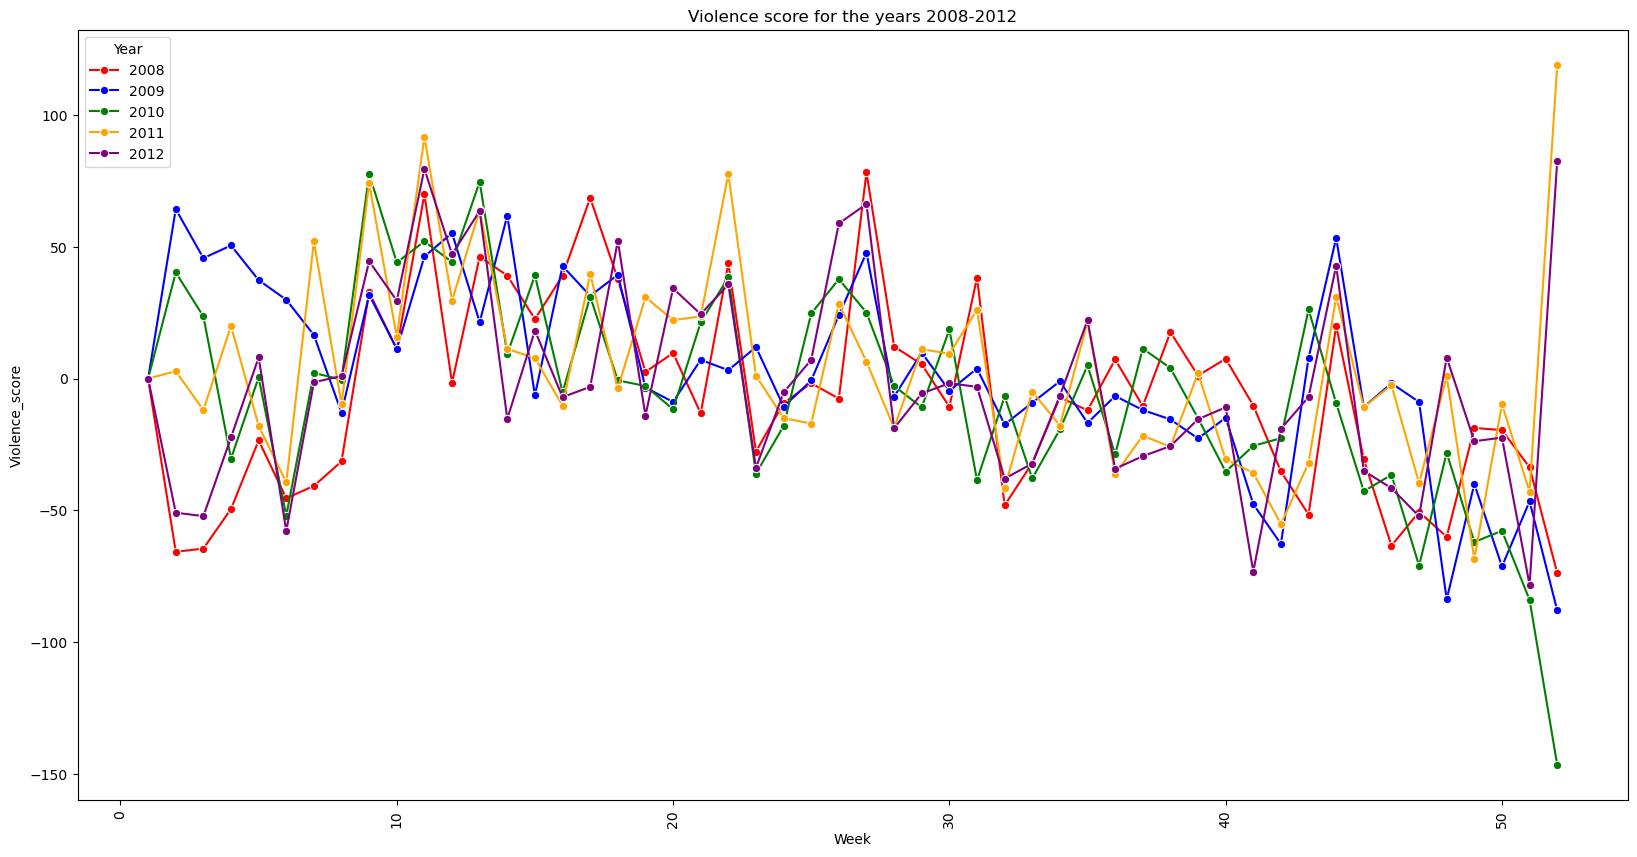

In [24]:
years = [2008, 2009, 2010, 2011, 2012]
year_colors = {
    2008: 'red',
    2009: 'blue',
    2010: 'green',
    2011: 'orange',
    2012: 'purple'
}
combined_df = z_scores_merged[z_scores_merged.Year.isin(years)]
plt.figure(figsize=(20, 10))
sns.lineplot(data=combined_df, x='Week', y='Violence_score', hue='Year', marker='o',palette=year_colors)
plt.title("Violence score for the years 2008-2012")
plt.xticks(rotation=90)
plt.show()


In [25]:
result_df = z_scores_merged.groupby('Year')["Violence_score"].sum()
result_df = result_df.reset_index(name='Aggregated violent scores')


Per year

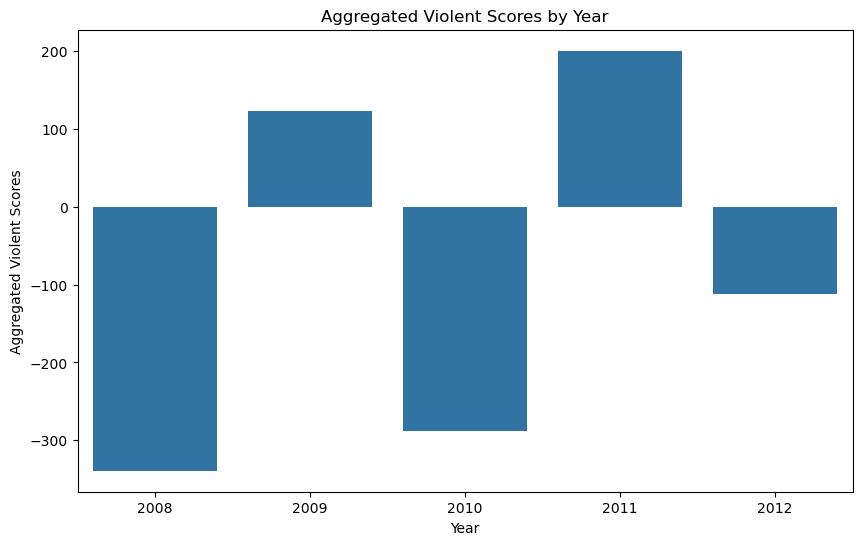

In [26]:
plt.figure(figsize=(10, 6))
sns.barplot(data=result_df, x='Year', y='Aggregated violent scores')
plt.title('Aggregated Violent Scores by Year')
plt.xlabel('Year')
plt.ylabel('Aggregated Violent Scores')
plt.show()

# Plots for count violent scores

In [27]:
import warnings
def violence_score_all_states_count(directory_path: str, start_year: int, end_year: int, start_week: int, stop_week: int, 
                                   ratio: bool = False, offenses: list = ['Assault Offenses', 'Robbery', 'Sex Offenses', 'Kidnapping/Abduction', 'Arson', 'Homicide Offenses']) -> dict:
   

    violence_scores_per_state = {}

    # Iterate through directory
    for filename in os.listdir(directory_path):

        state_scores_years = []

        # Check for .csv extension
        if filename.endswith(".csv"):
            file_path = os.path.join(directory_path, filename)

            # Extract state name (everything before first "_")
            state_name = filename.split("_")[0]
            dict_key = f"ARDL_{state_name}"

            # Load into dataframe
            real_violence_per_state = pd.read_csv(file_path, sep=",")

            with warnings.catch_warnings():

                warnings.filterwarnings("ignore")

                for year in range(start_year, end_year + 1):

                    # Compute real-life violence score for this state and year
                    weekly_score = real_life_violence_score_count(real_violence_per_state, year, start_week, stop_week, ratio)

                    # Convert to DataFrame
                    weekly_score_df = weekly_score.reset_index(name='violence_score')
                    weekly_score_df['year'] = year
                    state_scores_years.append(weekly_score_df)

                # Store in dict
                violence_scores_per_state[dict_key] = pd.concat(state_scores_years, axis=0, ignore_index=True)

    # Concatenate all dataframes for all states
    violence_scores_concat = pd.concat(violence_scores_per_state.values(), ignore_index=True)

    # Group by "Year" and "Week", sum up the violence scores
    violence_scores_merged = violence_scores_concat.groupby(["year", "week"], as_index=False).agg({"violence_score": "sum"})

    # Renaming the columns for consistency
    violence_scores_merged.columns.values[0] = "Year"
    violence_scores_merged.columns.values[1] = "Week"
    violence_scores_merged.columns.values[2] = "Violence_score"

    return violence_scores_merged


In [38]:
violent_score_ratio_merged = violence_score_all_states_count(DATA_PATH, 2008, 2012, 1, 52, ratio=True)
violent_score_merged = violence_score_all_states_count(DATA_PATH, 2008, 2012, 1, 52, ratio=False)

Accross years per week

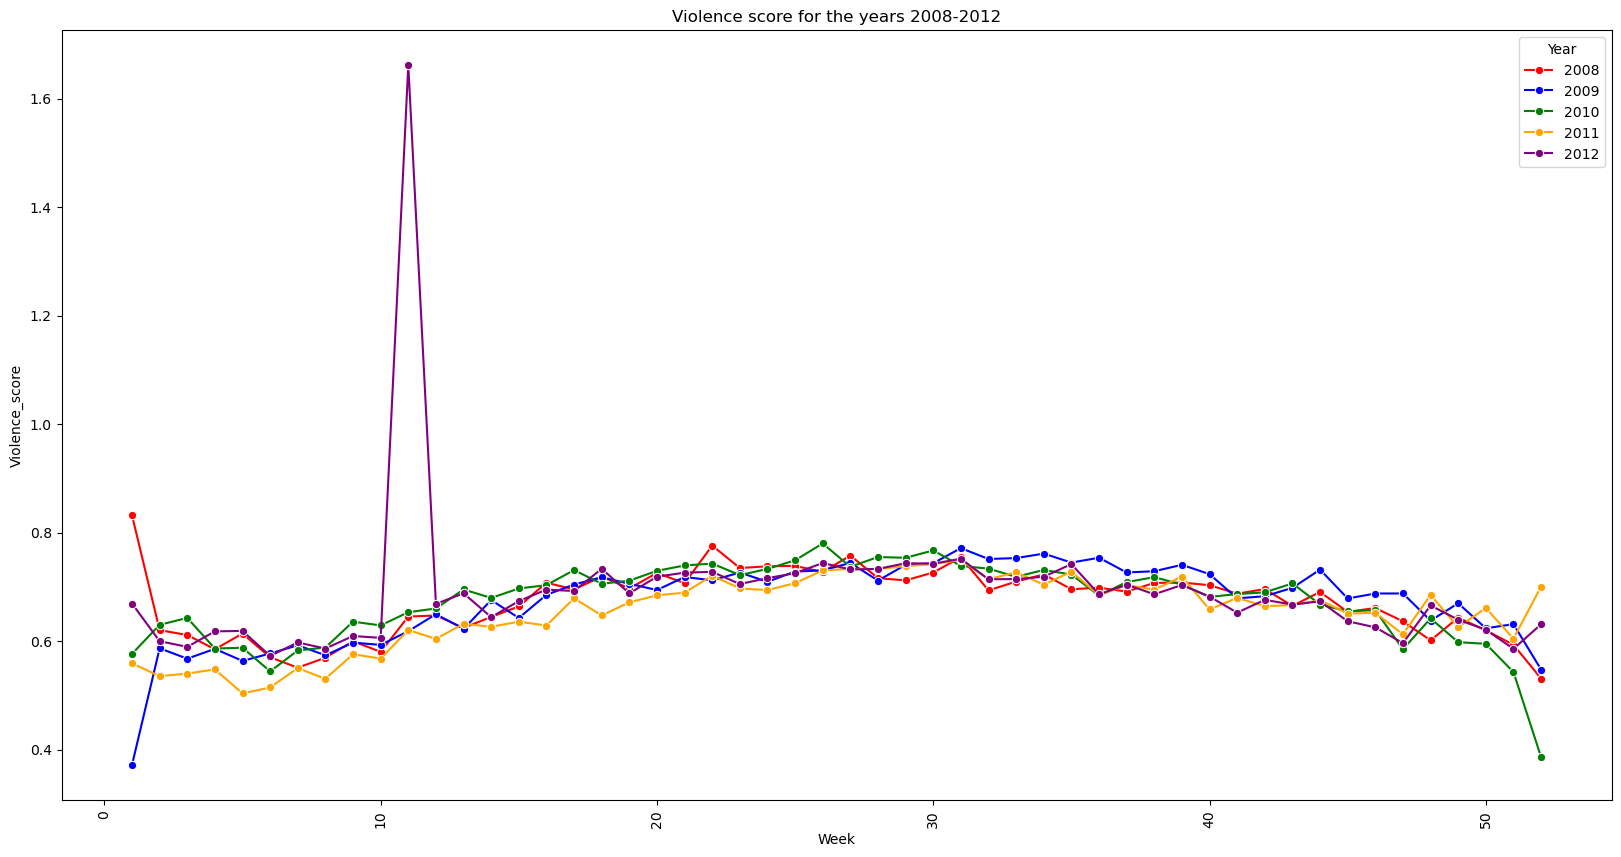

In [39]:
years = [2008, 2009, 2010, 2011, 2012]
year_colors = {
    2008: 'red',
    2009: 'blue',
    2010: 'green',
    2011: 'orange',
    2012: 'purple'
}
combined_df_ratio = violent_score_ratio_merged[violent_score_ratio_merged.Year.isin(years)]
plt.figure(figsize=(20, 10))
sns.lineplot(data=combined_df_ratio, x='Week', y='Violence_score', hue='Year', marker='o',palette=year_colors)
plt.title("Violence score for the years 2008-2012")
plt.xticks(rotation=90)
plt.show()

In [40]:
result_df_ratio = violent_score_ratio_merged.groupby('Year')["Violence_score"].sum()
result_df_ratio = result_df_ratio.reset_index(name='Aggregated violent scores')


Per year

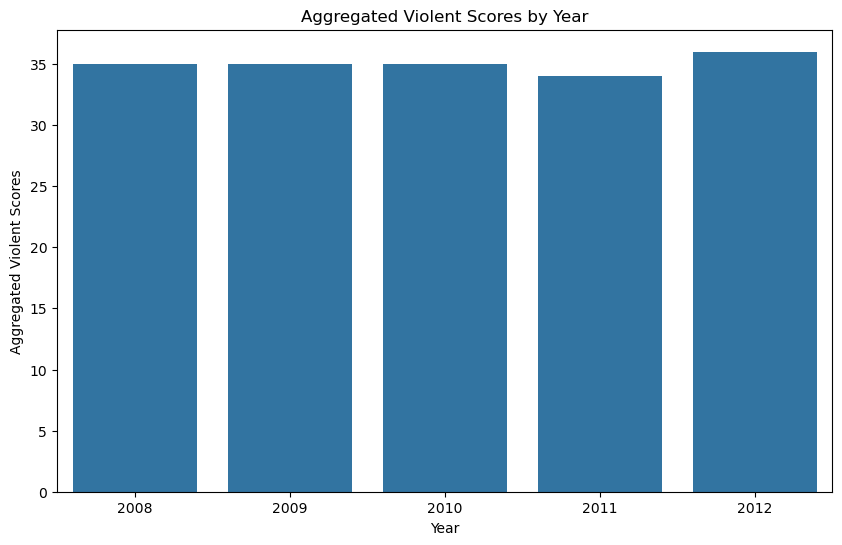

In [41]:
plt.figure(figsize=(10, 6))
sns.barplot(data=result_df_ratio, x='Year', y='Aggregated violent scores')
plt.title('Aggregated Violent Scores by Year')
plt.xlabel('Year')
plt.ylabel('Aggregated Violent Scores')
plt.show()

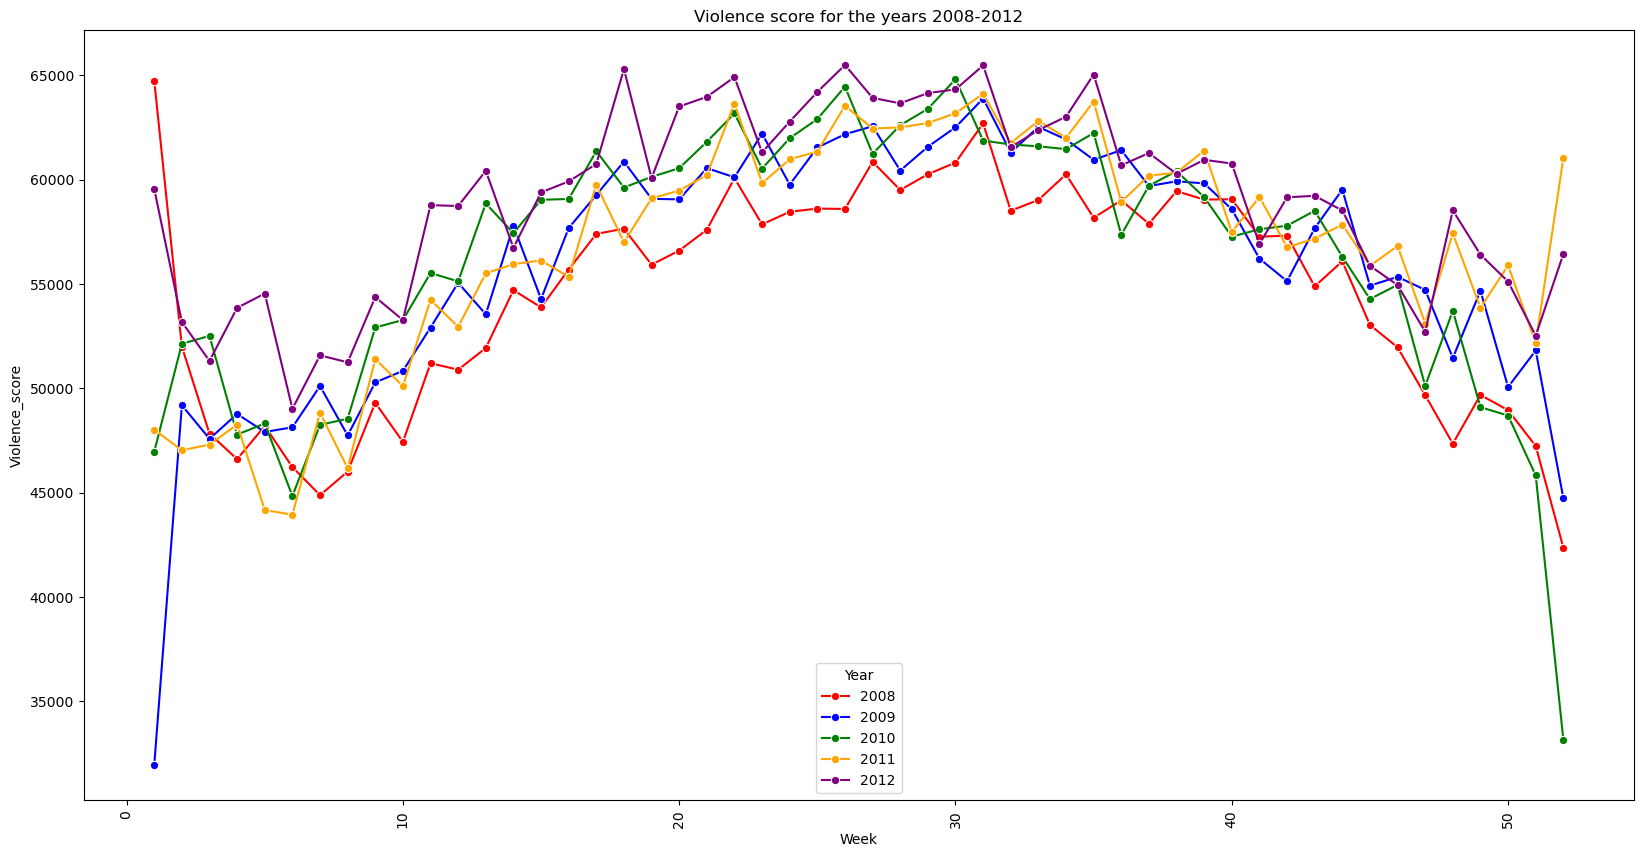

In [42]:
years = [2008, 2009, 2010, 2011, 2012]
year_colors = {
    2008: 'red',
    2009: 'blue',
    2010: 'green',
    2011: 'orange',
    2012: 'purple'
}
combined_df = violent_score_merged[violent_score_merged.Year.isin(years)]
plt.figure(figsize=(20, 10))
sns.lineplot(data=combined_df, x='Week', y='Violence_score', hue='Year', marker='o',palette=year_colors)
plt.title("Violence score for the years 2008-2012")
plt.xticks(rotation=90)
plt.show()

In [44]:
result_df = violent_score_merged.groupby('Year')["Violence_score"].sum()
result_df = result_df.reset_index(name='Aggregated violent scores')


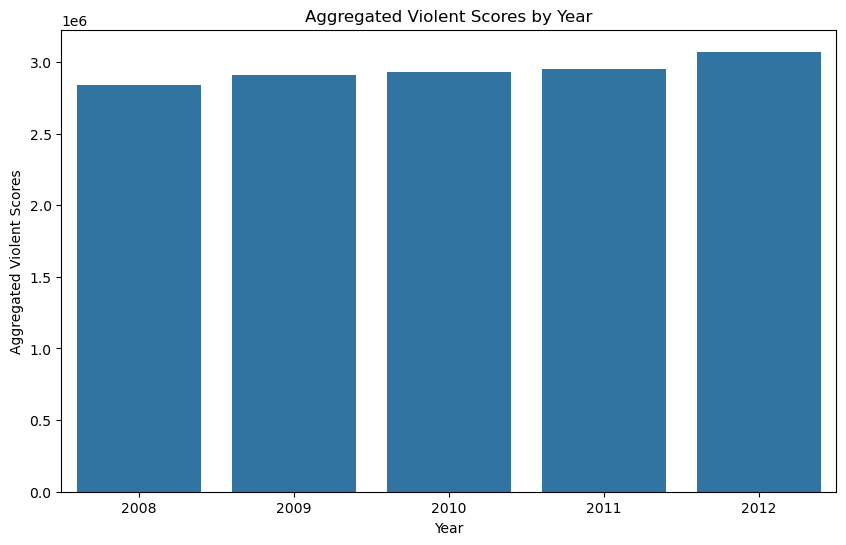

In [48]:
plt.figure(figsize=(10, 6))
sns.barplot(data=result_df, x='Year', y='Aggregated violent scores')
plt.title('Aggregated Violent Scores by Year')
plt.xlabel('Year')
plt.ylabel('Aggregated Violent Scores')
plt.show()